# HW1-2:Optimization
1.Visualize the optimization process

2.Observe gradient norm during training

3.Observe what happen when gradient norm is almost zero


In [ ]:
%tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import math
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
print(tf.version)

<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.6/tensorflow_core/_api/v1/version/__init__.py'>


In [ ]:
# load data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

tf.reset_default_graph()
data.test.cls = np.argmax(data.test.labels, axis=1)

# data information
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

# data preparation
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

# build model
net = tf.layers.conv2d(inputs=x_image, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
net = tf.layers.flatten(net)

net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)
# optimization and loss
y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
loss = tf.reduce_mean(cross_entropy)
opt = tf.train.AdamOptimizer(learning_rate=0.01)
optimizer = opt.minimize(loss)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [ ]:
# get weight 
trainable_var_list = tf.trainable_variables()
def get_weights_variable(layer_name):
    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')
    return variable

weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')
weights_fc1 = get_weights_variable(layer_name='layer_fc1')
weights_fc_out = get_weights_variable(layer_name='layer_fc_out')
weight_model=[weights_conv1,weights_conv2,weights_fc1,weights_fc_out]           # model weight

In [ ]:
# build section
session = tf.Session()
session.run(tf.global_variables_initializer())

# gradient norm and loss
grads = tf.gradients(loss, weights_fc_out)[0]
grads_norm = tf.norm(grads)

# Hessian Computation
hessian = tf.reduce_sum(tf.hessians(loss, weights_fc_out)[0], axis = 2)

# calculate the minimal-ratio
eigenvalue = tf.linalg.eigvalsh(hessian)
minimal_ratio = tf.divide(tf.count_nonzero(tf.greater(eigenvalue, 0.)),(eigenvalue.shape[0]*eigenvalue.shape[1]))


In [ ]:
# test evaluation
test_batch_size = 256
def print_test_accuracy():
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]

        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
print_test_accuracy()

Accuracy on Test-Set: 9.2% (916 / 10000)


In [ ]:
#training process
total_iterations=0
total_weight=[session.run(weight_model)]
layer1_weight=[session.run(weights_conv1)]
train_accuracy=[]
train_loss=[]
train_grad=[]
train_minimal=[]
def optimize(num_iterations):
    
    global total_iterations,total_weight,layer1_weight
    
    for i in range(total_iterations,total_iterations + num_iterations):


        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        feed_dict_train = {x: x_batch,y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)
        los, acc= session.run([loss, accuracy], feed_dict=feed_dict_train)
        train_loss.append(los)
        train_accuracy.append(acc)
        grads_vals, minimal_vals = session.run([grads_norm, minimal_ratio], feed_dict=feed_dict_train)
        train_grad.append(grads_vals)
        train_minimal.append(minimal_vals)
        # Print status every 10 iterations.
        if i % 10 == 0:
            # Calculate the accuracy on the training-set.
            los, acc= session.run([loss, accuracy], feed_dict=feed_dict_train)
            w1,w_m=session.run([weights_conv1,weight_model])
            total_weight.append(w_m)
            layer1_weight.append(w1)
            grads_vals, hess_vals = session.run([grads, hessian], feed_dict=feed_dict_train)
            msg = "Iteration: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}"
            print(msg.format(i + 1, los, acc))
    total_iterations += num_iterations
total_iterations=0
train_batch_size = 64
optimize(num_iterations=100)

Iteration:      1, Training Loss: 2.26767, Training Accuracy:  12.5%
Iteration:     11, Training Loss: 0.937644, Training Accuracy:  68.8%
Iteration:     21, Training Loss: 0.346487, Training Accuracy:  90.6%
Iteration:     31, Training Loss: 0.169538, Training Accuracy:  93.8%
Iteration:     41, Training Loss: 0.052735, Training Accuracy: 100.0%
Iteration:     51, Training Loss: 0.0979759, Training Accuracy:  96.9%
Iteration:     61, Training Loss: 0.102889, Training Accuracy:  95.3%
Iteration:     71, Training Loss: 0.0979732, Training Accuracy:  98.4%
Iteration:     81, Training Loss: 0.0896998, Training Accuracy:  95.3%
Iteration:     91, Training Loss: 0.164663, Training Accuracy:  96.9%


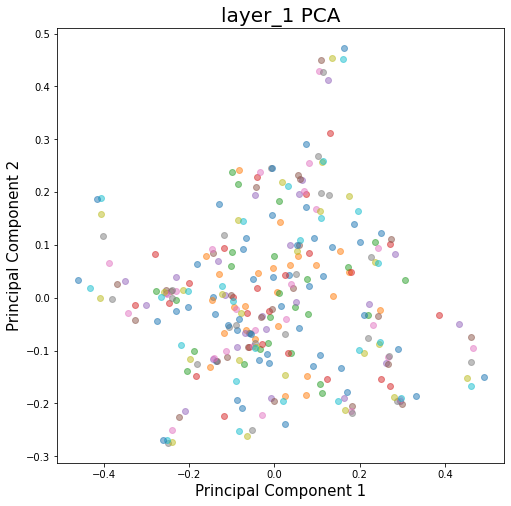

In [ ]:
# optimization for layer
from sklearn.decomposition import PCA
def plot_weights_layer(weights_list):
    pca = PCA(n_components=2)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('layer_1 PCA', fontsize = 20)
    for w in weights_list:    
      if len(w.shape)>2:
        r_w=w.reshape(-1,w.shape[-1])
      principalComponents = pca.fit_transform(r_w)
      ax.scatter(principalComponents[:,0], principalComponents[:,1],alpha=0.5)
    plt.show()
plot_weights_layer(weights_list=layer1_weight)

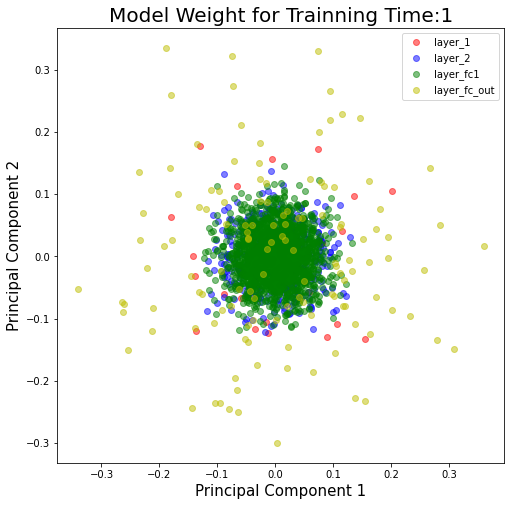

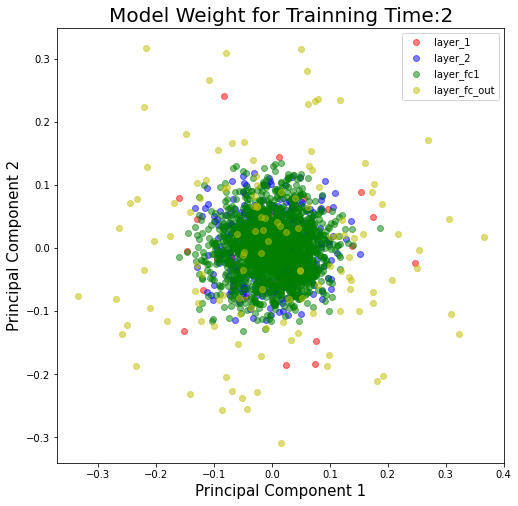

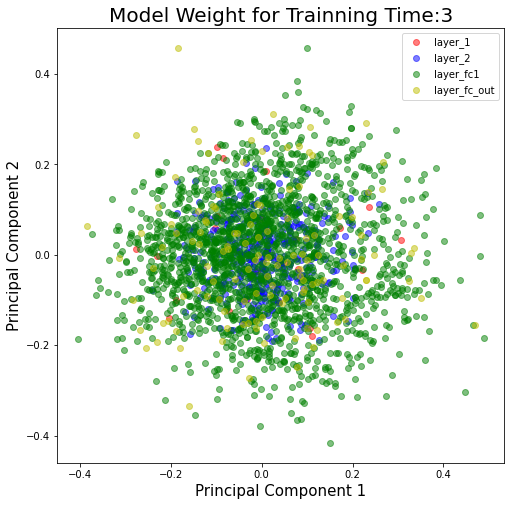

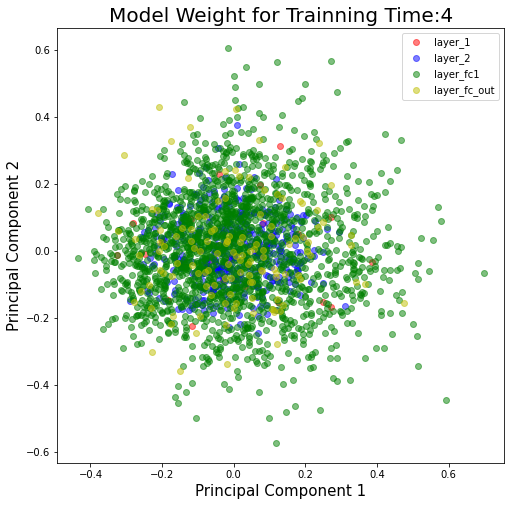

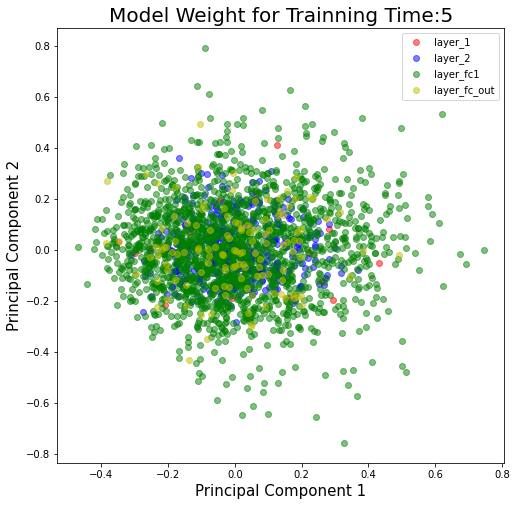

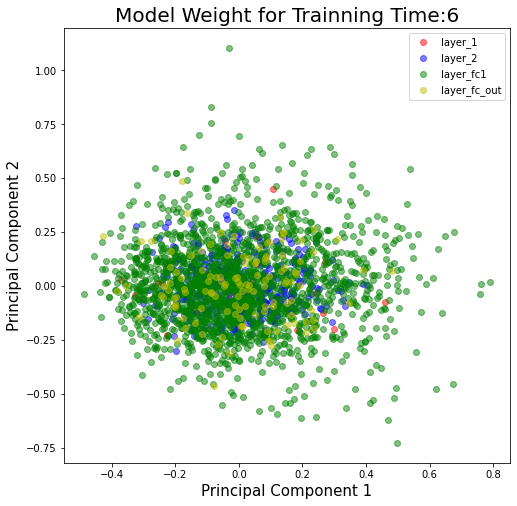

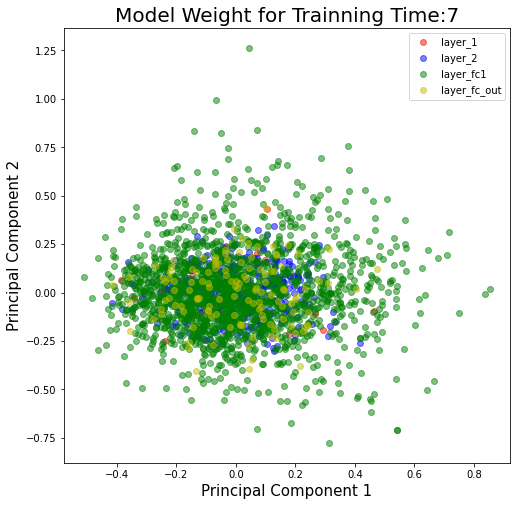

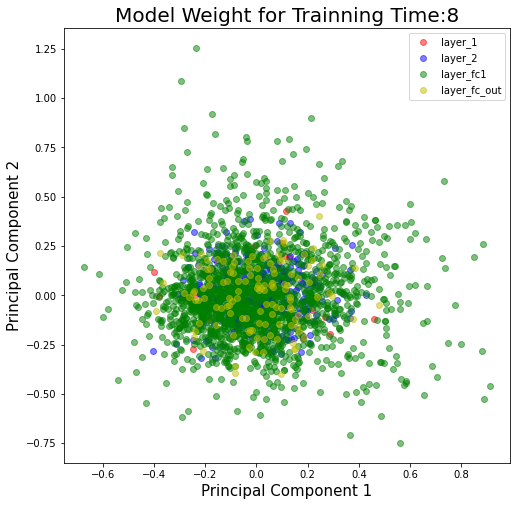

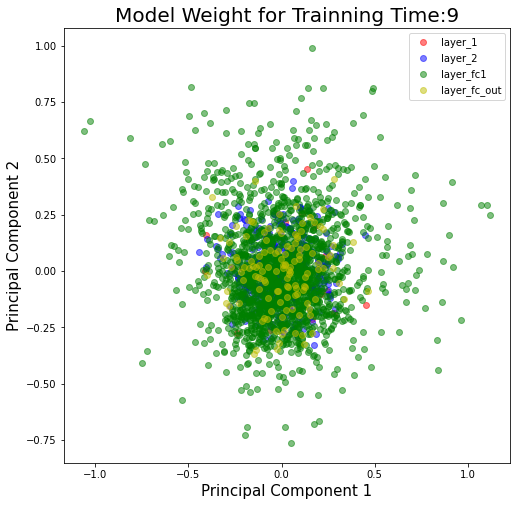

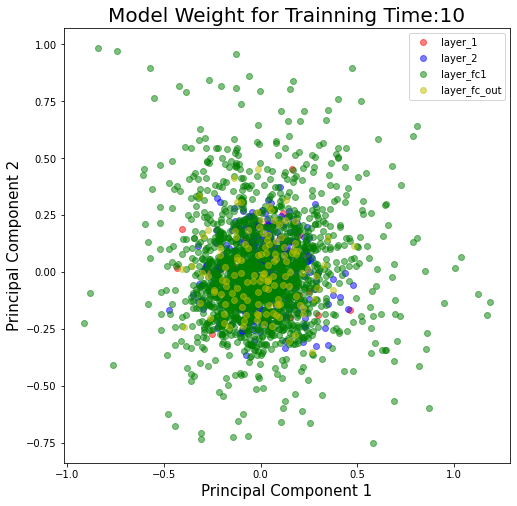

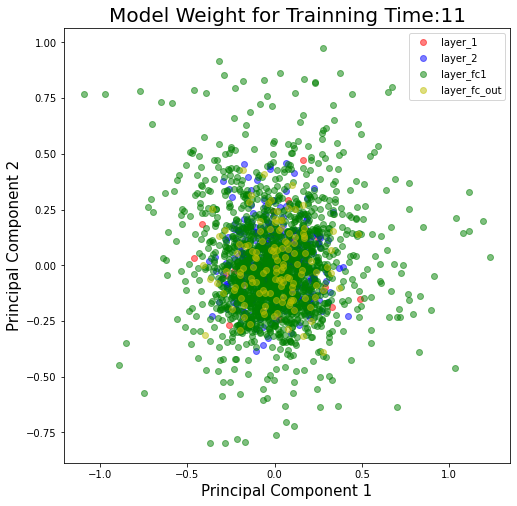

In [ ]:
col=['r','b','g','y','k']
def plot_model_weights(weights_list):
    pca = PCA(n_components=2)
    for j,w in enumerate(weights_list):
      fig = plt.figure(figsize = (8,8))
      plt.xlabel('Principal Component 1', fontsize = 15)
      plt.ylabel('Principal Component 2', fontsize = 15)
      plt.title('Model Weight for Trainning Time:{:d}'.format(j+1), fontsize = 20)
      for i,w_s in enumerate(w):
        if len(w_s.shape)>2:
          w_s=w_s.reshape(-1,w_s.shape[-1])
        principalComponents = pca.fit_transform(w_s)
        plt.scatter(principalComponents[:,0], principalComponents[:,1],label=w_s.shape,alpha=0.5,color=col[i])
      plt.legend(['layer_1','layer_2','layer_fc1','layer_fc_out'])
      plt.show()
plot_model_weights(weights_list=total_weight)

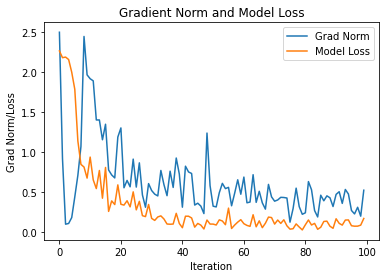

In [ ]:

plt.plot(train_grad)
plt.plot(train_loss)
plt.xlabel('Iteration')
plt.ylabel('Grad Norm/Loss')
plt.legend(['Grad Norm','Model Loss'])
plt.title("Gradient Norm and Model Loss")
plt.show()

Text(0.5, 1.0, 'Minimal Ratio vs Loss')

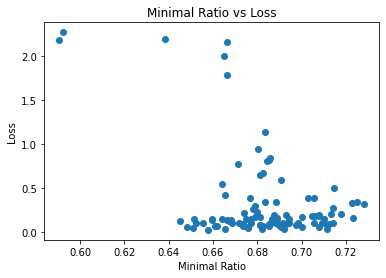

In [ ]:
plt.pause(0.1)
plt.scatter(train_minimal,train_loss)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss');
plt.title('Minimal Ratio vs Loss')

Epoch:  0 Loss:  0.13180503 Minimal Ratio:  0.7054687500000001
Epoch:  10 Loss:  0.15892236 Minimal Ratio:  0.7132812500000001
Epoch:  20 Loss:  0.114394285 Minimal Ratio:  0.6890625
Epoch:  30 Loss:  0.15727201 Minimal Ratio:  0.69453125
Epoch:  40 Loss:  0.19024503 Minimal Ratio:  0.7156250000000001
Epoch:  50 Loss:  0.16178118 Minimal Ratio:  0.7171875000000001
Epoch:  60 Loss:  0.3216582 Minimal Ratio:  0.7390625000000001
Epoch:  70 Loss:  0.074194364 Minimal Ratio:  0.7351562500000001
Epoch:  80 Loss:  0.20551711 Minimal Ratio:  0.7296875
Epoch:  90 Loss:  0.19883049 Minimal Ratio:  0.7351562500000001


Text(0, 0.5, 'Loss')

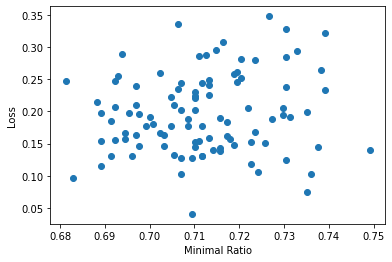

In [ ]:
grad_norm_train_op = opt.minimize(grads_norm)
EPOCH = 100
grads_loss_list = []
min_ratio_list2 = []
for i in range(EPOCH):
    x_batch, y_true_batch = data.train.next_batch(train_batch_size)
    feed_dict_train = {x: x_batch,y_true: y_true_batch}
    grads_vals, minimal_vals,l = session.run([grad_norm_train_op, minimal_ratio,loss], feed_dict=feed_dict_train)
    grads_loss_list.append(l)
    min_ratio_list2.append(minimal_vals)
    if i%10 == 0:
        print("Epoch: ",i,"Loss: ",l,"Minimal Ratio: ",minimal_vals)
plt.scatter(min_ratio_list2,grads_loss_list)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.show()